<a href="https://colab.research.google.com/github/sugi-san/iPERCore/blob/main/everybody_dance_advance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

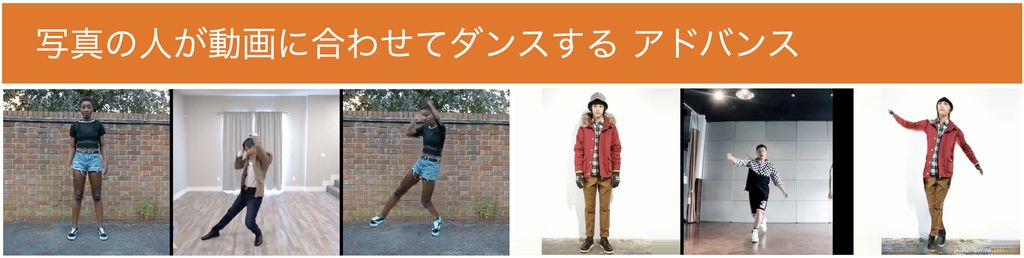

**1.これは「写真の人が動画に合わせてダンスする」を使ったことがある方むけのアドバンス版です**\
**2.アップロードする動画は必ず「１人のみ全身」が写っているものを使用して下さい**\
**3.「画像と動画の表示」の部分は、動画の表示がリスト表示に変更になっています**\
**4.新たな動画の変換時間が加わるため「動画の生成」の処理時間は倍くらいになります**

In [ ]:
#@title 1.セットアップ（約10分かかります）
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      # ffmpegインストール
      !apt-get install ffmpeg

      # CUDAセッティング
      import os
      os.environ["CUDA_HOME"] = "/usr/local/cuda-11"
      !echo $CUDA_HOME
      pbar.update(5)

      # githubからコードをコピー
      !git clone https://github.com/sugi-san/iPERCore.git
      %cd /content/iPERCore/
      pbar.update(5)

      # セットアッププログラムの実行
      #!python setup.py develop
      ! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.1 -f https://download.pytorch.org/whl/torch_stable.html
      ! pip install mmcv-full==1.2.2
      ! pip install git+https://github.com/open-mmlab/mmdetection.git@8179440ec5f75fe95484854af61ce6f6279f3bbc
      ! pip install git+https://github.com/open-mmlab/mmediting@d4086aaf8a36ae830f1714aad585900d24ad1156
      ! pip install git+https://github.com/iPERDance/neural_renderer.git@e5f54f71a8941acf372514eb92e289872f272653
      ! pip install tensorboardX>=2.1
      pbar.update(60)

      # 重みのダウンロード
      ! pip install --upgrade gdown
      import gdown
      gdown.download('https://drive.google.com/uc?id=1jpp_KytMplNNFA_IJSzzSWhvyqIdmnJv', 'assets/checkpoints.zip', quiet=False)
      !unzip -o assets/checkpoints.zip -d assets/
      !rm assets/checkpoints.zip
      pbar.update(10)

      # サンプルのダウンロード
      !wget -O assets/samples.zip  "https://download.impersonator.org/iper_plus_plus_latest_samples.zip"
      !unzip -o assets/samples.zip -d  assets
      !rm assets/samples.zip
      pbar.update(10)

      # 動画処理情報のダウンロード
      gdown.download('https://drive.google.com/uc?id=11WEpRSqqAdvmzsDveaCdLkE4ohro3diA', './results1.zip', quiet=False)
      ! unzip results1.zip
      gdown.download('https://drive.google.com/uc?id=1ehlpa7PcqhRonr2mEJ6vvtr2Mnr-BbkG', './results2.zip', quiet=False)
      ! unzip results2.zip
      pbar.update(10)

except subprocess.CalledProcessError:
  print(captured)
  raise

# ディレクトリ移動
%cd /content/iPERCore/

# ライブラリーのインポート
import os
import os.path as osp
import platform
import argparse
import time
import sys
import subprocess
from IPython.display import HTML
from base64 import b64encode


#--- 初期設定 ---
# the gpu ids
gpu_ids = "0"

# the image size
image_size = 512

# the default number of source images, it will be updated if the actual number of sources <= num_source
num_source = 2

# the assets directory. This is very important, please download it from `one_drive_url` firstly.
assets_dir = "/content/iPERCore/assets"

# the output directory.
output_dir = "./results"

# the model id of this case. This is a random model name.
# model_id = "model_" + str(time.time())

# # This is a specific model name, and it will be used if you do not change it.
# model_id = "axing_1"

# symlink from the actual assets directory to this current directory
work_asserts_dir = os.path.join("./assets")
if not os.path.exists(work_asserts_dir):
    os.symlink(osp.abspath(assets_dir), osp.abspath(work_asserts_dir),
               target_is_directory=(platform.system() == "Windows"))

cfg_path = osp.join(work_asserts_dir, "configs", "deploy.toml")


#---関数定義---
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import glob

# 汎用画像ファイル表示
def display_pic(folder):
    fig = plt.figure(figsize=(20, 20))
    files = os.listdir(folder)
    files.sort()
    for i, file in enumerate(files):
        if file == '.ipynb_checkpoints':
          continue
        if file == '.DS_Store':
          continue  
        img = Image.open(folder+'/'+file) 
        images = np.asarray(img)
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        ax.set_xlabel(file, fontsize=20)               
    plt.show()
    plt.close()

# movie表示（専用画像使用）
def display_movie(folder):
    fig = plt.figure(figsize=(20, 20))
    files = os.listdir(folder)
    files.sort()
    for i, file in enumerate(files):
        if file == '.ipynb_checkpoints':
          continue
        if file == '.DS_Store':
          continue             
        img = Image.open(folder+'/'+file) 
        images = np.asarray(img)
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        ax.set_xlabel(file[:-4]+'.mp4', fontsize=20)               
    plt.show()
    plt.close()

# フォルダー名＋ペア画像表示用サブ
def display_pic_mini(folder):
    fig = plt.figure(figsize=(20, 20))
    files = os.listdir(folder)
    files.sort()
    for i, file in enumerate(files):
        if file == '.ipynb_checkpoints':
          continue
        if file == '.DS_Store':
          continue   
        img = Image.open(folder+'/'+file) 
        images = np.asarray(img)
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        #ax.set_xlabel(file, fontsize=20)               
    plt.show()
    plt.close()

# フォルダー名＋ペア画像表示用メイン
def display_pic_double(folder):
    folders = glob.glob(os.path.join(folder,'*'))
    folders.sort()
    for folder in folders:
        print(folder[11:])
        display_pic_mini(folder)

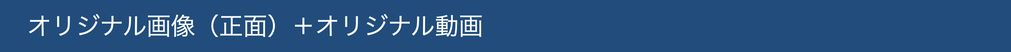

In [ ]:
#@title 2.画像のアップロード
import os
import shutil
from google.colab import files

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートからpicフォルダーへ移動
for i in range(len(uploaded)):
    shutil.move(uploaded[i], './single/pic/'+uploaded[i])

In [ ]:
#@title 3.動画のアップロード
import os
import shutil
from google.colab import files

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートからpicフォルダーへ移動
for i in range(len(uploaded)):
    shutil.move(uploaded[i], './single/movie/'+uploaded[i])

In [ ]:
#@title 4.画像と動画の表示
print('===== pic =====')
display_pic('single/pic')

print('===== movie =====')
import os
files = os.listdir('./single/movie')
files.sort()
for file in files:
    print(file)

In [ ]:
#@title 5.動画の生成
from pathlib import Path
pic = ''#@param {type:"string"}
movie = ''#@param {type:"string"}
pic_name = Path(pic).stem
movie_name = Path(movie).stem

# This is a specific model name, and it will be used if you do not change it. This is the case of `trump`
#model_id = "donald_trump_2"
model_id = "test01"

# the source input information, here \" is escape character of double duote "
#src_path = "\"path?=/content/iPERCore/assets/samples/sources/donald_trump_2/00000.PNG,name?=donald\""
src_path = "\"path?=/content/iPERCore/single/pic/"+pic+",name?="+pic_name+"\""

#ref_path = "\"path?=/content/iPERCore/movie/d1.mp4,"  \
ref_path = "\"path?=/content/iPERCore/single/movie/"+movie+"," \
             "name?="+movie_name+"," \
             "pose_fc?=300\""

print(ref_path)

!python -m iPERCore.services.run_imitator  \
  --gpu_ids     $gpu_ids       \
  --num_source  $num_source    \
  --image_size  $image_size    \
  --output_dir  $output_dir    \
  --model_id    $model_id      \
  --cfg_path    $cfg_path      \
  --src_path    $src_path      \
  --ref_path    $ref_path

In [ ]:
#@title 6.動画の再生
mp4 = open('results/primitives/'+pic_name+'/synthesis/imitations/'+pic_name+'-'+movie, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width="85%" height="85%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

In [ ]:
#@title 7.動画のダウンロード
from google.colab import files
files.download('results/primitives/'+pic_name+'/synthesis/imitations/'+pic_name+'-'+movie)

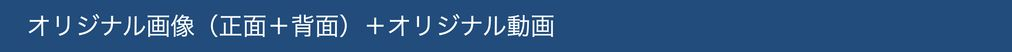

In [ ]:
#@title 8.前後画像のアップロード
#@markdown ・前を向いた画像（000.jpg）と後ろを向いた画像（001.jpg）をペアでアップロードして下さい
import os
import shutil

# フォルダ内のフォルダ数（ファイル数）をカウント
# 但し、'.ipynb_checkpoints'　はカウントしない
def count_folder(path):
    folders = os.listdir(path)
    offset = 0 
    for folder in folders:
        if folder == '.ipynb_checkpoints':
          offset = 1
    num = len(os.listdir(path))-offset
    return num

# ファイル数が2でないフォルダは削除
folders = os.listdir('double/pic')
for folder in folders:
    num = count_folder('double/pic/'+folder) # ファイル数カウント 
    if num != 2: 
      shutil.rmtree('double/pic/'+folder)  # 削除

# 新規フォルダの作成
number = count_folder('double/pic') #  フォルダ数カウント
folder_path = 'double/pic/f'+str(number+1).zfill(2)  # フォルダ名設定
os.makedirs(folder_path, exist_ok=True)

# 画像をルートへアップロード
from google.colab import files
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートから新規フォルダへ移動
for i in range(len(uploaded)):
    shutil.move(uploaded[i], folder_path+'/'+uploaded[i])

In [ ]:
#@title 9.動画のアップロード
import os
import shutil
from google.colab import files

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートからmovieフォルダーへ移動
for i in range(len(uploaded)):
    shutil.move(uploaded[i], './double/movie/'+uploaded[i])

In [ ]:
#@title 10.フォルダーと動画の表示
print('===== folder =====')
display_pic_double('double/pic')

print('===== movie =====')
import os
files = os.listdir('./double/movie')
files.sort()
for file in files:
    print(file)

In [ ]:
#@title 11.動画の生成
from pathlib import Path
folder = ''#@param {type:"string"}
movie = ''#@param {type:"string"}
movie_name = Path(movie).stem

# This is a specific model name, and it will be used if you do not change it. This is the case of `trump`
#model_id = "axing_1"
model_id = "test02"

# the source input information, here \" is escape character of double duote "
src_path = "\"path?=/content/iPERCore/double/pic/"+folder+",name?="+folder+"\""


## the reference input information. There are three reference videos in this case.
# here \" is escape character of double duote "
ref_path = "\"path?=/content/iPERCore/double/movie/"+movie+"," \
             "name?="+movie_name+"," \
             "pose_fc?=300\""

print(ref_path)

!python -m iPERCore.services.run_imitator  \
  --gpu_ids     $gpu_ids       \
  --num_source  $num_source    \
  --image_size  $image_size    \
  --output_dir  $output_dir    \
  --model_id    $model_id      \
  --cfg_path    $cfg_path      \
  --src_path    $src_path      \
  --ref_path    $ref_path

In [ ]:
#@title 12.動画の再生
mp4 = open("./results/primitives/"+folder+"/synthesis/imitations/"+folder+"-"+movie, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width="85%" height="85%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

In [ ]:
#@title 13.動画のダウンロード
from google.colab import files
files.download('results/primitives/'+folder+'/synthesis/imitations/'+folder+'-'+movie)

###【備考】
・動作がおかしくなった場合は、右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックして、再度１番から順番に操作を行います。

・このノートを実行して閉じてから、すぐ再度実行する場合は、前の記憶が不完全に残っていて上手く動かないことがあります。その場合は、右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックして、再度１番から操作を行います。

・長時間使用するとgoogleから使用制限を受ける場合がありますが、12h〜24h程度経つと使用制限が解除されます。